# Bounding boxes

Task description: "Provide accurate bounding boxes for UI elements”

Inputs:

- Image
- Element name/description

Ouputs:

- Dimensions of bounding box

It looks like many VLMs have not been trained on this task and so do not perform well. This notebook contains tests with the most performant models as of today (2024-10-10).

In [1]:
from mllm import Router, Prompt
from threadmem import RoleThread
from pydantic import BaseModel
from PIL import Image, ImageDraw
from agentdesk import Desktop
from surfninja.img import b64_to_image, image_to_b64, crop_box_around
import os
import getpass
import pathlib

We will use the same image for the tests

In [2]:
image_path = pathlib.Path("test.jpg")

In [3]:
if not image_path.exists():
    desktop = Desktop.gce()
    desktop.open_url("https://google.com")
    image = b64_to_image(desktop.take_screenshot())
    image.save(image_path, format="JPEG")

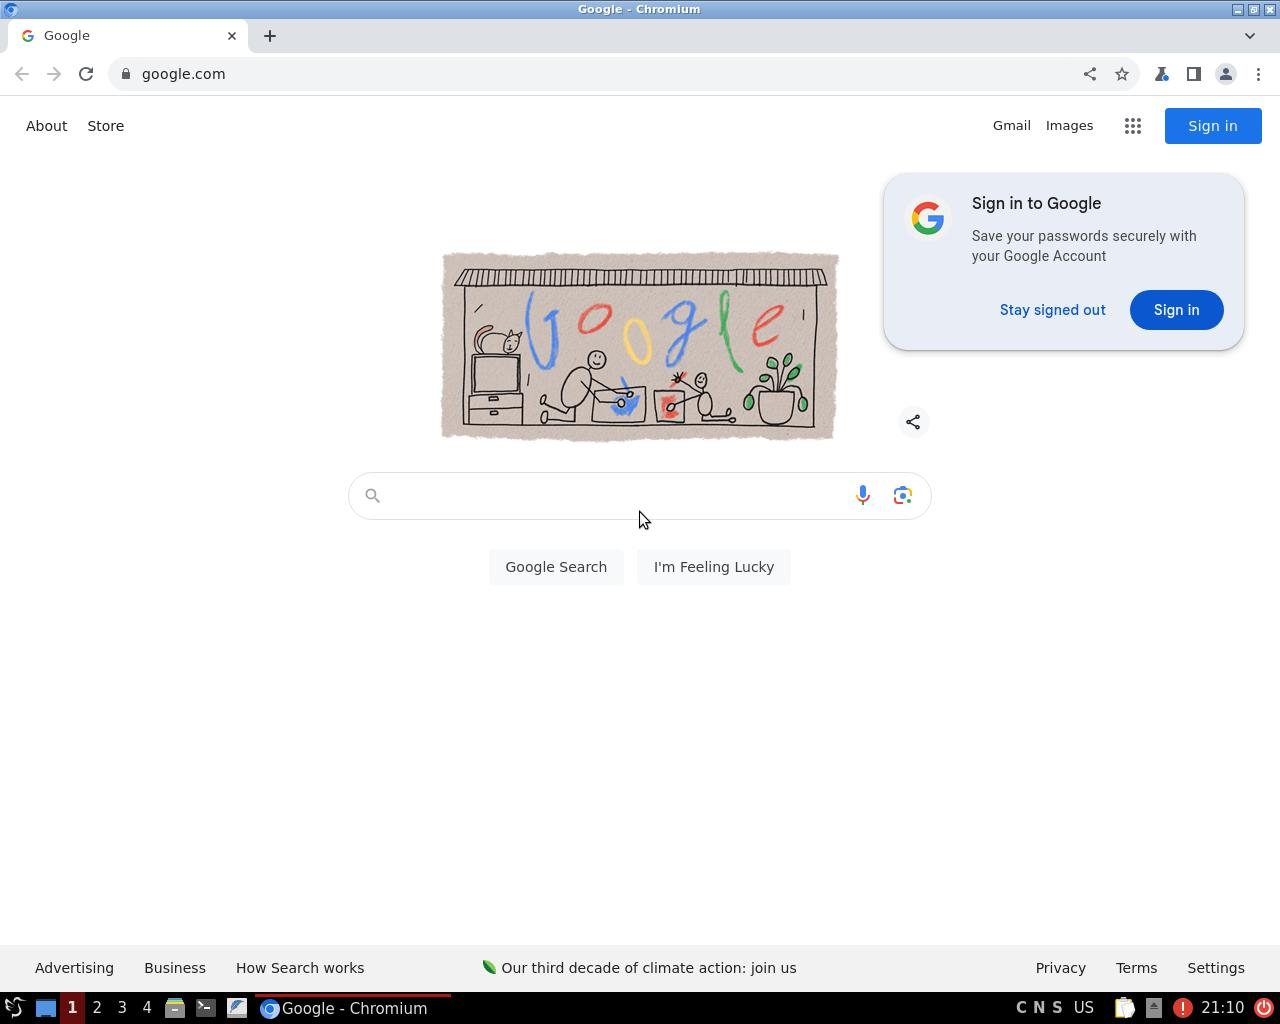

In [4]:
image = Image.open(str(image_path))
image

In [5]:
image_b64 = image_to_b64(image, image_format="JPEG")

In [6]:
image.size

(1280, 1024)

We'll also define a baseline image to verify that the models can indeed detect objects, even if they have not been trained on UI elements.

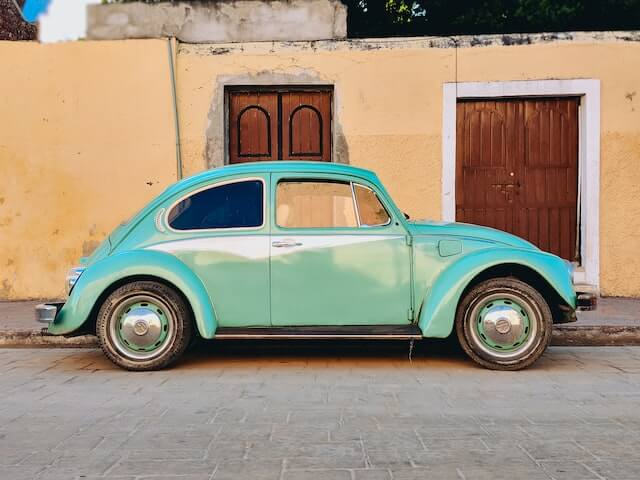

In [7]:
baseline_image = Image.open(str(pathlib.Path("baseline.jpg")))
baseline_image_b64 = image_to_b64(baseline_image, image_format="JPEG")
baseline_image

Throughout the notebook we'll try to draw a bounding box over the "About button"

In [8]:
element = "About button"
baseline_element = "car"

## Gemini

Gemini has been reported to perform well with this task, so we will try with this one first.

In [9]:
secret = getpass.getpass(prompt='Enter Gemini API key: ')

In [10]:
os.environ["GEMINI_API_KEY"] = secret

In [11]:
router = Router(
    preference=["gemini/gemini-1.5-pro-latest"]
)

Intialized router with Routing strategy: simple-shuffle

Routing fallbacks: None

Routing context window fallbacks: None

Router Redis Caching=None


In [13]:
class BoundingBox(BaseModel):
    y_min: int
    x_min: int
    y_max: int
    x_max: int

In [14]:
schema = BoundingBox.model_json_schema()
schema

{'properties': {'y_min': {'title': 'Y Min', 'type': 'integer'},
  'x_min': {'title': 'X Min', 'type': 'integer'},
  'y_max': {'title': 'Y Max', 'type': 'integer'},
  'x_max': {'title': 'X Max', 'type': 'integer'}},
 'required': ['y_min', 'x_min', 'y_max', 'x_max'],
 'title': 'BoundingBox',
 'type': 'object'}

In [15]:
prompt_template = """Detect the {element} in the image. Return its position using the following JSON format:

{{
    "y_min": $Y_MIN,
    "x_min": $X_MIN,
    "y_max": $Y_MAX,
    "x_max": $X_MAX

}}

Full schema:

{schema}

Do not use code blocks. Return the JSON string only."""

In [16]:
prompt = prompt_template.format(element=element, schema=schema)
prompt

'Detect the About button in the image. Return its position using the following JSON format:\n\n{\n    "y_min": $Y_MIN,\n    "x_min": $X_MIN,\n    "y_max": $Y_MAX,\n    "x_max": $X_MAX\n\n}\n\nFull schema:\n\n{\'properties\': {\'y_min\': {\'title\': \'Y Min\', \'type\': \'integer\'}, \'x_min\': {\'title\': \'X Min\', \'type\': \'integer\'}, \'y_max\': {\'title\': \'Y Max\', \'type\': \'integer\'}, \'x_max\': {\'title\': \'X Max\', \'type\': \'integer\'}}, \'required\': [\'y_min\', \'x_min\', \'y_max\', \'x_max\'], \'title\': \'BoundingBox\', \'type\': \'object\'}\n\nDo not use code blocks. Return the JSON string only.'

In [17]:
baseline_prompt = prompt_template.format(element=baseline_element, schema=schema)
baseline_prompt

'Detect the car in the image. Return its position using the following JSON format:\n\n{\n    "y_min": $Y_MIN,\n    "x_min": $X_MIN,\n    "y_max": $Y_MAX,\n    "x_max": $X_MAX\n\n}\n\nFull schema:\n\n{\'properties\': {\'y_min\': {\'title\': \'Y Min\', \'type\': \'integer\'}, \'x_min\': {\'title\': \'X Min\', \'type\': \'integer\'}, \'y_max\': {\'title\': \'Y Max\', \'type\': \'integer\'}, \'x_max\': {\'title\': \'X Max\', \'type\': \'integer\'}}, \'required\': [\'y_min\', \'x_min\', \'y_max\', \'x_max\'], \'title\': \'BoundingBox\', \'type\': \'object\'}\n\nDo not use code blocks. Return the JSON string only.'

Baseline...

In [17]:
thread = RoleThread()
thread.post(
    role="user",
    msg=baseline_prompt,
    images=[baseline_image_b64],
)

response = router.chat(thread, expect=BoundingBox, retries=0)

/home/arturo/anaconda3/envs/surfninja/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
response.parsed

BoundingBox(y_min=314, x_min=52, y_max=786, x_max=917)

In [19]:
box = response.parsed
# gemini uses 1000x1000 imgs so we need to convert back to our dims
y_min = int(box.y_min / 1000 * baseline_image.height)
x_min = int(box.x_min / 1000 * baseline_image.width)
y_max = int(box.y_max / 1000 * baseline_image.height)
x_max = int(box.x_max / 1000 * baseline_image.width)

In [20]:
(y_min, x_min, y_max, x_max)

(150, 33, 377, 586)

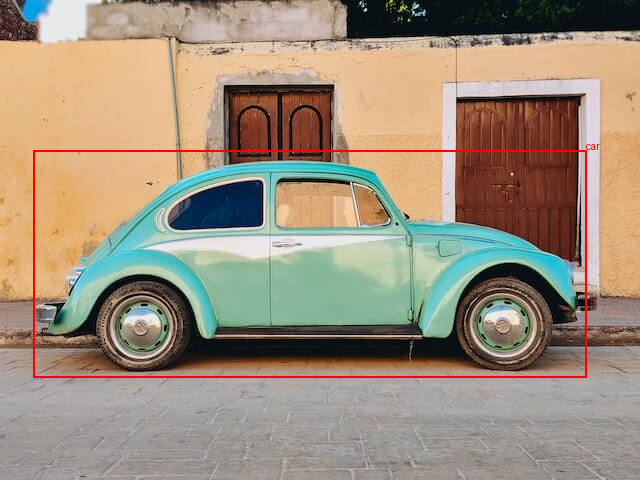

In [21]:
# plot the img with the bounding box
baseline_img_copy = baseline_image.copy()
draw = ImageDraw.Draw(baseline_img_copy)
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
draw.text((x_max, y_min - 10), baseline_element, fill="red")
baseline_img_copy

Looks like it does pretty good. Let's try it with the Google search box in the screenshot now

In [22]:
thread = RoleThread()
thread.post(
    role="user",
    msg=prompt,
    images=[image_b64],
)

response = router.chat(thread, expect=BoundingBox, retries=0)

In [23]:
response.parsed

BoundingBox(y_min=112, x_min=41, y_max=131, x_max=81)

In [24]:
box = response.parsed
# gemini uses 1000x1000 imgs so we need to convert back to our dims
y_min = int(box.y_min / 1000 * image.height)
x_min = int(box.x_min / 1000 * image.width)
y_max = int(box.y_max / 1000 * image.height)
x_max = int(box.x_max / 1000 * image.width)

In [25]:
(y_min, x_min, y_max, x_max)

(114, 52, 134, 103)

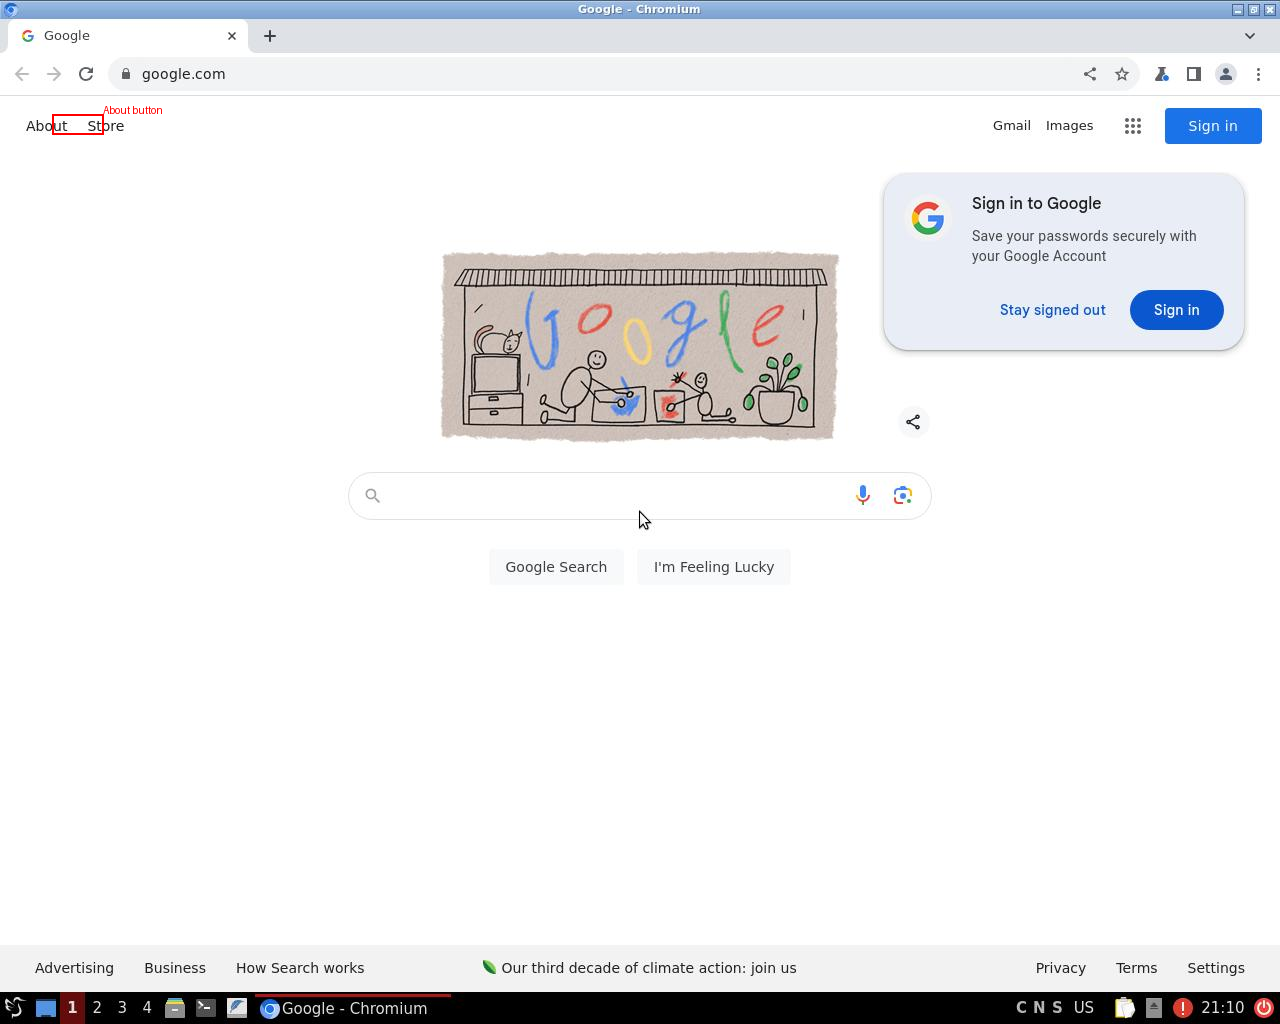

In [26]:
# plot the img with the bounding box
img_copy = image.copy()
draw = ImageDraw.Draw(img_copy)
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
draw.text((x_max, y_min - 10), element, fill="red")
img_copy

As we can see, it's not great... Let's try another model.

## GPT-4o

GPT-4o is another capable model (see https://rank.opencompass.org.cn/leaderboard-multimodal). Let's try that.

In [27]:
secret = getpass.getpass(prompt='Enter OpenAI API key: ')

In [28]:
os.environ["OPENAI_API_KEY"] = secret

In [29]:
router = Router(
    preference=["gpt-4o"]
)

Intialized router with Routing strategy: simple-shuffle

Routing fallbacks: None

Routing context window fallbacks: None

Router Redis Caching=None


In [30]:
thread = RoleThread()
thread.post(
    role="user",
    msg=baseline_prompt,
    images=[baseline_image_b64],
)

response = router.chat(thread, expect=BoundingBox, retries=0)


In [31]:
response.parsed

BoundingBox(y_min=150, x_min=50, y_max=450, x_max=600)

In [32]:
box = response.parsed
# unsure if gpt4o needs normalization
y_min = box.y_min
x_min = box.x_min
y_max = box.y_max
x_max = box.x_max

In [33]:
(y_min, x_min, y_max, x_max)

(150, 50, 450, 600)

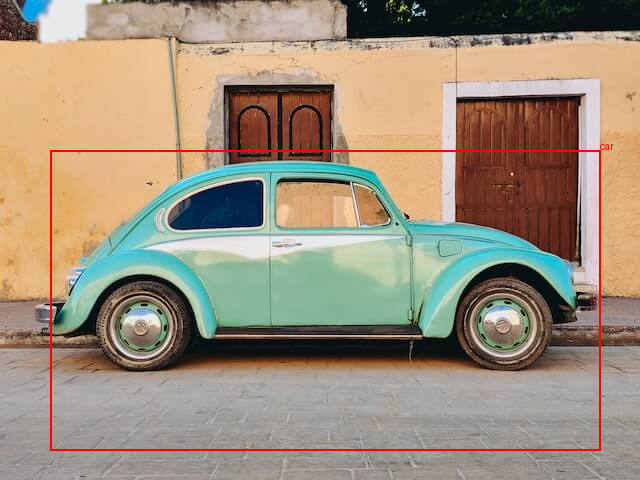

In [34]:
# plot the img with the bounding box
baseline_img_copy = baseline_image.copy()
draw = ImageDraw.Draw(baseline_img_copy)
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
draw.text((x_max, y_min - 10), baseline_element, fill="red")
baseline_img_copy

It looks like it actually performs a little worse than Gemini. Let's try it with the UI anyway...

In [35]:
thread = RoleThread()
thread.post(
    role="user",
    msg=prompt,
    images=[image_b64],
)

response = router.chat(thread, expect=BoundingBox, retries=0)

In [36]:
response.parsed

BoundingBox(y_min=20, x_min=17, y_max=41, x_max=88)

In [37]:
box = response.parsed
# unsure if gpt4o needs normalization
y_min = box.y_min
x_min = box.x_min
y_max = box.y_max
x_max = box.x_max

In [38]:
(y_min, x_min, y_max, x_max)

(20, 17, 41, 88)

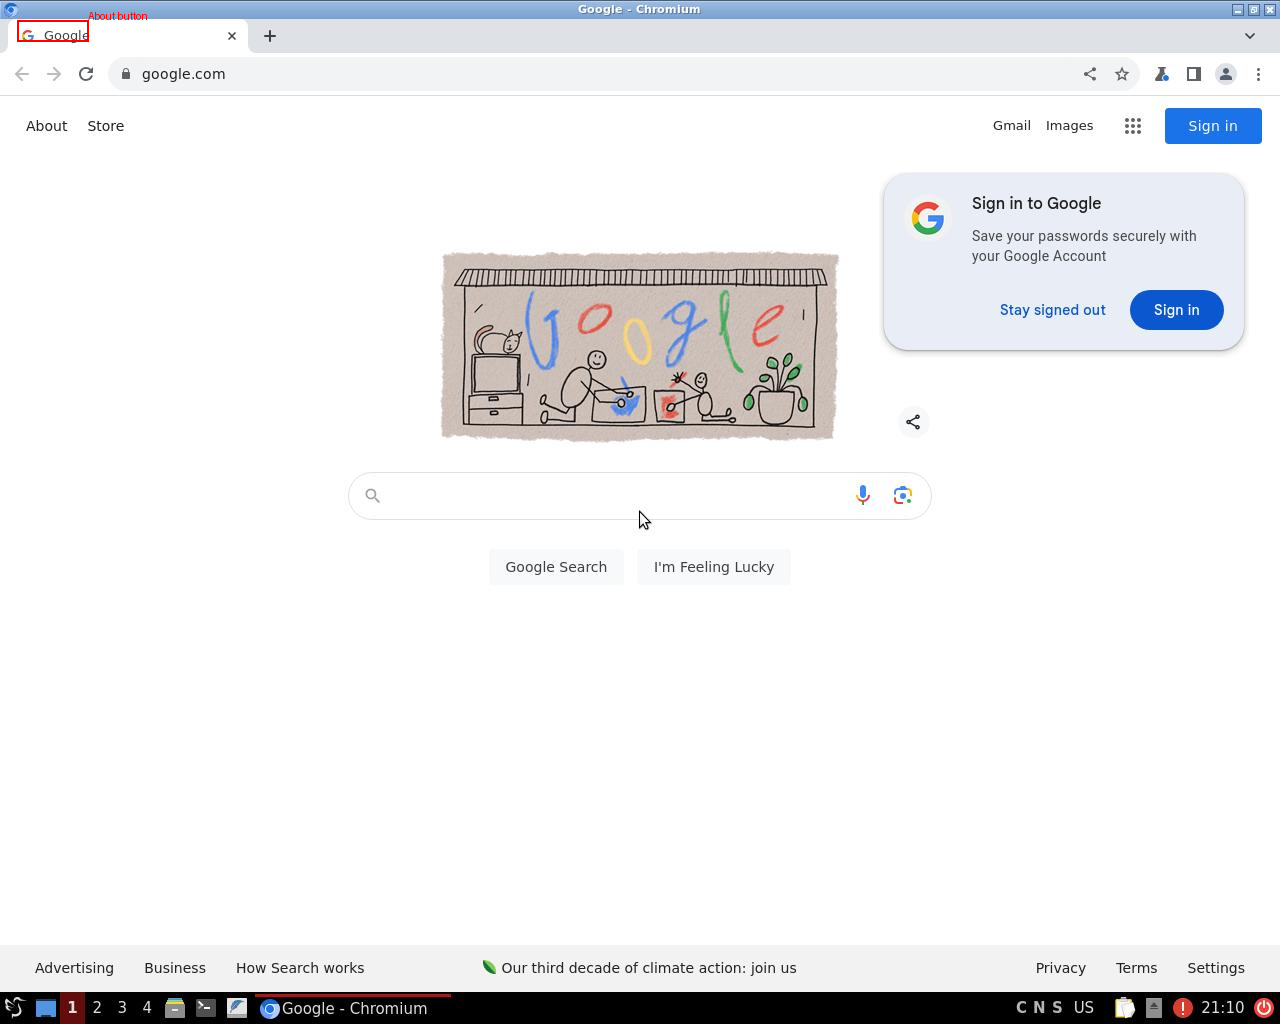

In [39]:
# plot the img with the bounding box
img_copy = image.copy()
draw = ImageDraw.Draw(img_copy)
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
draw.text((x_max, y_min - 10), element, fill="red")
img_copy

Pretty bad :(

## Claude 3.5

In [9]:
secret = getpass.getpass(prompt='Enter Anthropic API key: ')

In [10]:
os.environ["ANTHROPIC_API_KEY"] = secret

In [11]:
router = Router(
    preference=["anthropic/claude-3-5-sonnet-20240620"]
)

Intialized router with Routing strategy: simple-shuffle

Routing fallbacks: None

Routing context window fallbacks: None

Router Redis Caching=None


In [18]:
thread = RoleThread()
thread.post(
    role="user",
    msg=baseline_prompt,
    images=[baseline_image_b64],
)

response = router.chat(thread, expect=BoundingBox, retries=0)


In [19]:
response.parsed

BoundingBox(y_min=160, x_min=0, y_max=420, x_max=640)

In [20]:
box = response.parsed
# unsure if gpt4o needs normalization
y_min = box.y_min
x_min = box.x_min
y_max = box.y_max
x_max = box.x_max

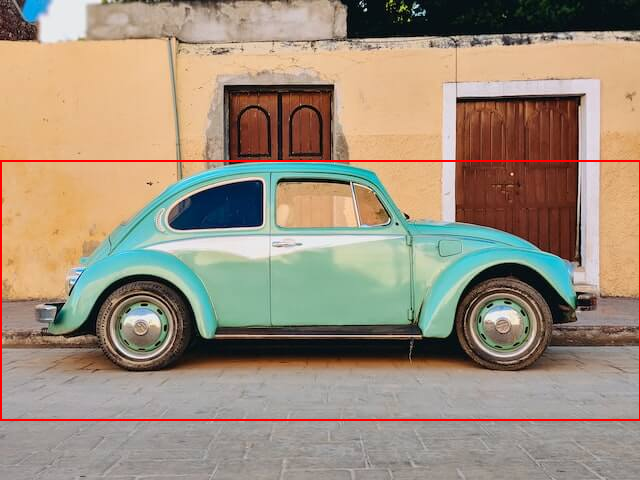

In [21]:
# plot the img with the bounding box
baseline_img_copy = baseline_image.copy()
draw = ImageDraw.Draw(baseline_img_copy)
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
draw.text((x_max, y_min - 10), baseline_element, fill="red")
baseline_img_copy

In [22]:
thread = RoleThread()
thread.post(
    role="user",
    msg=prompt,
    images=[image_b64],
)

response = router.chat(thread, expect=BoundingBox, retries=0)

In [23]:
response.parsed

BoundingBox(y_min=80, x_min=10, y_max=100, x_max=60)

In [24]:
box = response.parsed
# unsure if gpt4o needs normalization
y_min = box.y_min
x_min = box.x_min
y_max = box.y_max
x_max = box.x_max

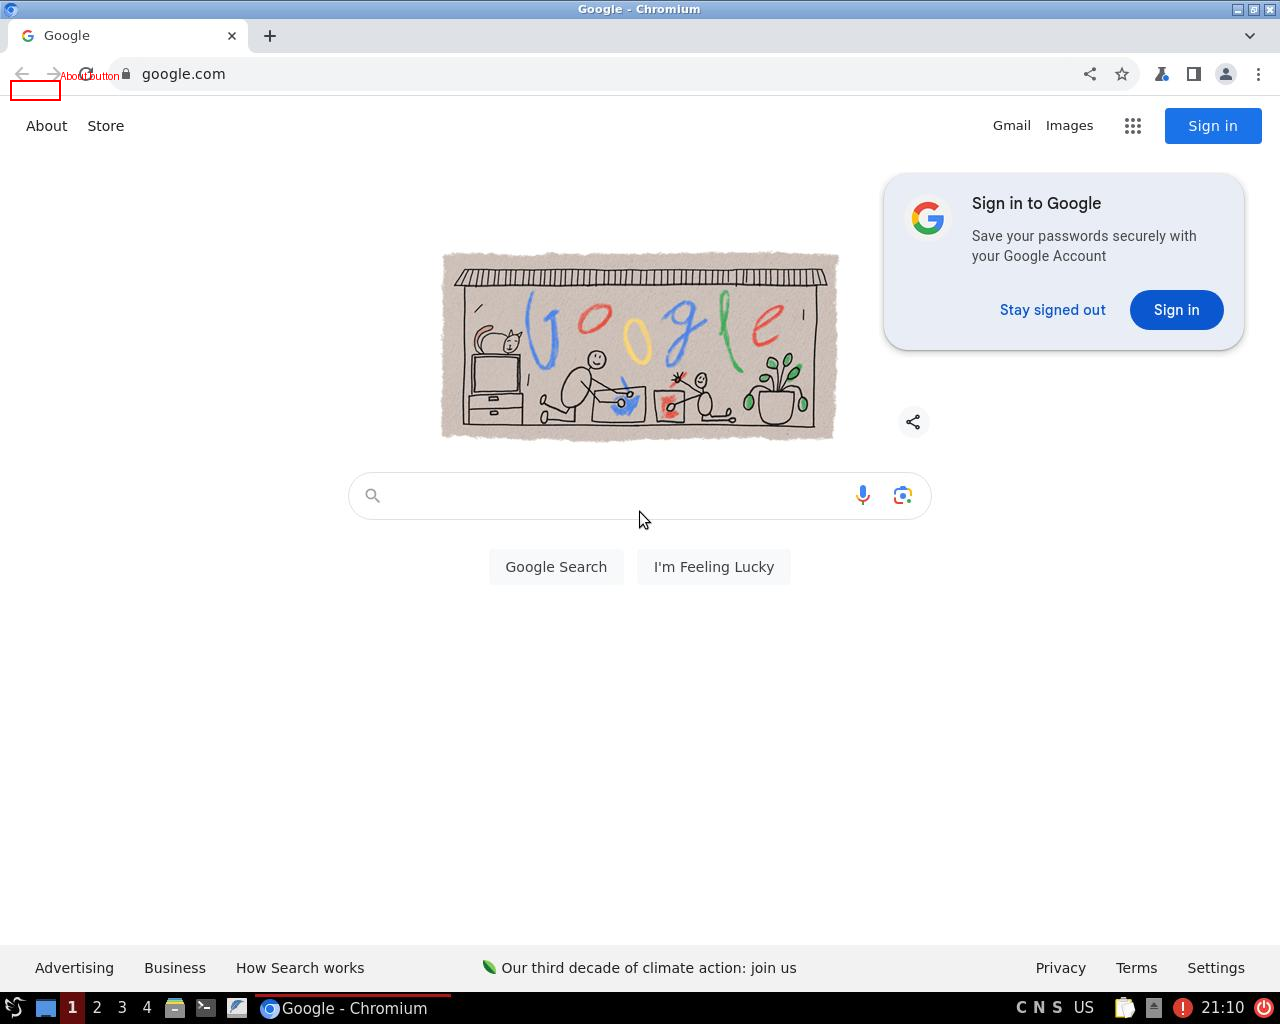

In [25]:
# plot the img with the bounding box
img_copy = image.copy()
draw = ImageDraw.Draw(img_copy)
draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
draw.text((x_max, y_min - 10), element, fill="red")
img_copy

## PaliGemma

The most natural thing would be to test some open models, like InternVL. However, so far it looks like even the big model **can** do object detection, but have not been trained to do so with UIs.

So the quesiton that arises, rather than being able to run open multimodal models, would be if we can fine-tune an open multimodal model on the specific task of creating bounding boxes around UI elements. Towards that goal, PaliGemma is a good candidate, with the following benefits:

- It is a good compromise between size and performance, meaning that it might be better for specific tasks.
- It is supposedly easy to fine-tune, and, actually, **meant** to be fine-tuned.
- Perhaps most importantly: it has already been trained on object detection!

See:

- https://huggingface.co/blog/paligemma
- https://blog.roboflow.com/paligemma-multimodal-vision/

PaliGemma is open and so can be run locally. To quickly check its capabilities we can use [this Colab](https://colab.research.google.com/drive/1fTH2l2YrQj7ykuar5E5KTEUfSIDG-BsQ?usp=sharing)

A quick run will reveal that PaliGemma does OK in the baseline example:

![](paligemma_baseline.png)

However, it performs badly with UIs.

![](paligemma_target.png)

This is not bad, though! We now have a candidate model for fine-tuning that can be fine-tuned easily due to its size (3B) and that already does object detection!

Now we only need the data. For that see the [WebUI notebook](./web_ui.ipynb)